In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
from tqdm import tqdm
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from cmocean.cm import phase as phase_cm

In [2]:
def gauss(x,mu=.5,sigma=.09):
    return 1/np.sqrt(2*np.pi*sigma**2)*np.exp((-(x-mu)**2)/(2*sigma**2))

In [3]:
npts = 2000
N = 1000 # number of time steps
X = np.linspace(-10,10,npts)
dx = X[1]-X[0]
dt = .04
print(X <-3)

V = np.zeros(npts)
V[X<-3]=10
V[X>3]=10

complex_I = np.ones(npts,complex)
alpha = 1j * dt/(2*dx**2)*complex_I
xi = complex_I+1j*dt/2*(2/(dx**2)*complex_I + V) 
diags = np.array([-1,0,1])
vecs1 =np.array([-alpha,xi,-alpha])
vecs2 =np.array([alpha,2-xi,alpha])
U1 = scipy.sparse.spdiags(vecs1,diags,npts,npts)
U2 = scipy.sparse.spdiags(vecs2,diags,npts,npts)
U1.tocsc()
U2.tocsc()
psi = np.zeros((npts,N),complex)
psi[:,0] = gauss(X,mu=0,sigma=1)+0j

[ True  True  True ..., False False False]


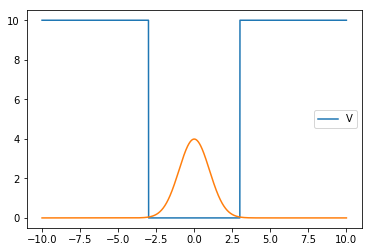

In [4]:
plt.plot(X,V,label='V')
plt.plot(X,10*np.abs(psi[:,0]))
plt.legend()
plt.show()

In [5]:
for n in range(N-1):
    b = U2.dot(psi[:,n])
    psi[:,n+1] = spsolve(csc_matrix(U1),b)

In [7]:
iterable = tqdm(range(N))
for i in iterable:
    plt.figure()
    plt.plot(X,V,label='V')
    plt.plot(X,10*np.abs(psi[:,i]),label=r'$\psi$')
    plt.legend(fontsize=20)
    plt.savefig('{:03d}.png'.format(i))
    plt.close()
    

100%|██████████| 1000/1000 [03:14<00:00,  5.13it/s]


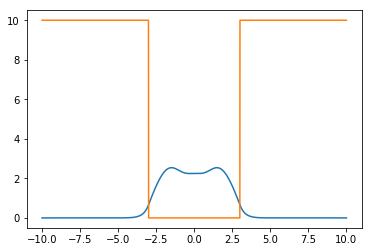

In [8]:
plt.plot(X,10*np.abs(psi[:,500]),label=r'$\psi$')
plt.plot(X,V,label='V')


In [17]:
iterable = tqdm(range(N))
for i in range(N):
    fig = plt.figure(figsize=(12,8))
    plt.plot(X,V,label='V')
    
    points = np.array([X,10*np.abs(psi[:,i])]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    axs = plt.gca()
    norm = plt.Normalize(-np.pi, np.pi)
    lc = LineCollection(segments, cmap=phase_cm, norm=norm)
    lc.set_array(np.angle(psi[:,i]))
    lc.set_linewidth(6)
    line = axs.add_collection(lc)
    fig.colorbar(line, ax=axs,label='Phase')
    plt.tight_layout()
    plt.savefig('{:03d}_phase.png'.format(i),dpi=250)
    plt.close()





  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
x = X
y = 10*np.abs(psi[:,500])
plt.plot(X,V,label='V')

def plot_phase_line:
    
points = np.array([X, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

axs = plt.gca()
norm = plt.Normalize(-np.pi, np.pi)
lc = LineCollection(segments, cmap=phase_cm, norm=norm)
lc.set_array(np.angle(psi[:,500]))
lc.set_linewidth(6)
line = axs.add_collection(lc)
fig.colorbar(line, ax=axs,label='Phase')

axs.set_xlim(x.min(), x.max())
plt.show()

SyntaxError: invalid syntax (<ipython-input-16-349de09134d8>, line 7)

In [144]:
np.angle(psi[:]).min()

-3.1415912042320739